# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix

data_dir = '../data'
output_dir = '../outputs'

In [2]:
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [3]:
embedding = MDS(n_components=16)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.526360285768192, pvalue=3.0674318985419923e-171)

In [4]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [5]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [6]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [7]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
np.array(concept_in_feat_coord).shape

(1854, 16)

In [8]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cr,bigcat,cat_name
0,0,0.071999,0.161435,0.039457,0.389236,-0.037558,0.446462,-0.065430,0.403851,-0.200719,-0.202378,-0.187901,-0.099644,0.247043,-0.265182,0.400593,-0.286854,0.779739,1,animal
1,1,-0.319577,0.184342,0.038835,0.141672,0.098267,0.140269,-0.106019,0.194534,0.052230,-0.165977,-0.137377,-0.304110,0.157817,0.369537,0.212740,-0.451698,0.798485,13,home decor
2,2,-0.392058,-0.144030,-0.115806,0.163674,0.064952,0.597918,-0.302299,0.002461,0.113075,-0.146125,-0.275193,-0.135056,0.236356,0.215873,0.152597,-0.347312,0.752845,18,musical instrument
4,4,-0.131091,-0.119339,-0.170014,-0.215163,0.281584,0.445175,0.039811,0.159509,0.094098,-0.089327,0.003694,-0.010457,-0.142375,-0.130144,0.182558,-0.474171,0.794466,9,electronic device
5,5,-0.063888,-0.056699,-0.150170,-0.010224,0.578841,0.181183,-0.058386,0.236284,0.180524,-0.118457,-0.091935,0.122819,0.300060,0.011361,0.019421,-0.127073,0.806000,12,furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.217186,0.348112,0.090563,0.324752,0.228564,0.354915,-0.165389,-0.095355,0.103772,0.001621,0.036448,-0.618364,-0.056354,-0.185772,-0.020339,0.424930,0.803129,24,toy
1848,1848,-0.013364,-0.078692,-0.231090,-0.117691,0.348011,0.473758,0.387285,0.117308,-0.022481,-0.324165,0.038612,-0.027557,0.283925,0.286119,0.254004,0.065341,0.765881,10,food
1850,1850,0.170096,-0.017859,-0.340803,0.013633,0.379376,0.545223,0.237368,0.051217,0.130945,-0.184359,0.015742,-0.076406,0.192011,0.265827,0.343072,0.093120,0.843158,10,food
1851,1851,0.114483,0.120792,0.141064,0.290152,-0.096254,0.376355,-0.252120,0.304115,-0.086557,-0.202872,-0.179114,0.001195,0.229714,-0.225854,0.238669,-0.440171,0.800163,1,animal


### Cartesian

In [9]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:15]
coordinates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.071999,0.161435,0.039457,0.389236,-0.037558,0.446462,-0.065430,0.403851,-0.200719,-0.202378,-0.187901,-0.099644,0.247043,-0.265182,0.400593,-0.286854
1,-0.319577,0.184342,0.038835,0.141672,0.098267,0.140269,-0.106019,0.194534,0.052230,-0.165977,-0.137377,-0.304110,0.157817,0.369537,0.212740,-0.451698
2,-0.392058,-0.144030,-0.115806,0.163674,0.064952,0.597918,-0.302299,0.002461,0.113075,-0.146125,-0.275193,-0.135056,0.236356,0.215873,0.152597,-0.347312
3,-0.214212,0.031427,-0.374599,-0.150945,0.249705,0.389255,-0.004785,0.052906,0.274497,-0.128109,-0.092479,-0.147278,0.301623,0.281618,0.595847,-0.198854
4,-0.131091,-0.119339,-0.170014,-0.215163,0.281584,0.445175,0.039811,0.159509,0.094098,-0.089327,0.003694,-0.010457,-0.142375,-0.130144,0.182558,-0.474171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,-0.250647,0.050198,0.143621,0.111629,0.376212,0.499818,0.168184,0.217062,-0.198825,-0.225574,-0.254276,-0.151420,0.134201,0.451165,0.541396,-0.308298
1850,0.170096,-0.017859,-0.340803,0.013633,0.379376,0.545223,0.237368,0.051217,0.130945,-0.184359,0.015742,-0.076406,0.192011,0.265827,0.343072,0.093120
1851,0.114483,0.120792,0.141064,0.290152,-0.096254,0.376355,-0.252120,0.304115,-0.086557,-0.202872,-0.179114,0.001195,0.229714,-0.225854,0.238669,-0.440171
1852,-0.071861,-0.218274,0.133833,0.085141,0.375422,0.512751,0.039443,0.384267,-0.232624,-0.372582,0.245161,0.049728,0.225567,-0.051905,0.360859,-0.119924


In [10]:
### linreg: cartesian coordinates and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     47.72
Date:                Sun, 27 Nov 2022   Prob (F-statistic):          4.97e-126
Time:                        17:37:13   Log-Likelihood:                -2308.5
No. Observations:                1854   AIC:                             4651.
Df Residuals:                    1837   BIC:                             4745.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.3897      0.119      3.283      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.293584
rsquared_adj,0.287431
coef,"[0.3897449668398281, 0.16261748802105214, 0.43..."
pvalues,"[0.0010458700801954115, 0.19469236198022216, 0..."
AIC,4651.064045
BIC,4744.990758
F-statistic,47.715716
F-stats-prob,0.0
Log-Likelihood,-2308.532023


### Polar coordinates

In [12]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


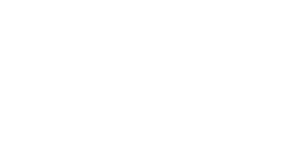

(array([  2.,   6.,  36., 137., 306., 536., 457., 257.,  98.,  19.]),
 array([0.44319305, 0.54387664, 0.64456022, 0.7452438 , 0.84592739,
        0.94661097, 1.04729455, 1.14797814, 1.24866172, 1.3493453 ,
        1.45002889]),
 <BarContainer object of 10 artists>)

In [13]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [14]:
### Radius vs. memorability
# Euclidean: R^2 = 0.006, adjsuted = 0.005
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary(xname=['radius','const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.612
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.204
Time:                        17:37:13   Log-Likelihood:                -2629.9
No. Observations:                1854   AIC:                             5264.
Df Residuals:                    1852   BIC:                             5275.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.2083      0.164     -1.270      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results


,cart_coord_mem,radius_mem
rsquared,0.293584,0.00087
rsquared_adj,0.287431,0.00033
coef,"[0.3897449668398281, 0.16261748802105214, 0.43...","[-0.2083056086067026, 0.21490304622903292]"
pvalues,"[0.0010458700801954115, 0.19469236198022216, 0...","[0.204383113687831, 0.20861429543481733]"
AIC,4651.064045,5263.811133
BIC,4744.990758,5274.861334
F-statistic,47.715716,1.611909
F-stats-prob,0.0,0.204383
Log-Likelihood,-2308.532023,-2629.905566


### KMeans

In [16]:
## import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1401.103782269289, 1194.1182530271922, 1066.6225457923065, 976.5266328834175, 907.638163795909, 863.0245961351379, 820.3507907623167, 780.6349036803648, 753.378210221343, 728.6659871474681, 707.6251024769182, 691.5558792605378, 678.6842317553151, 667.6729638283974]


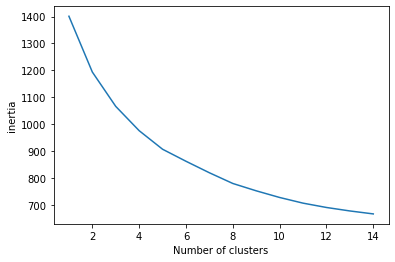

In [17]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [18]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[ 0.03517273, -0.03356699, -0.20603301, -0.13768055,  0.25389936,
         0.32284993,  0.12768764,  0.15343866, -0.00166961, -0.26326406,
        -0.1199554 , -0.05707515,  0.14531501,  0.30652215,  0.25633847,
        -0.05888678],
       [ 0.06194033,  0.10020848, -0.0731305 ,  0.18823781,  0.10126458,
         0.19228889, -0.11041883,  0.25889352, -0.09805949, -0.11444856,
        -0.06103252, -0.03733539,  0.17916198, -0.11146027,  0.24085645,
        -0.29654962],
       [-0.08763376, -0.11320539,  0.00260724, -0.10648018,  0.18309915,
         0.08766623, -0.05863662,  0.17590248, -0.18832217, -0.11317751,
         0.40978642,  0.2136061 ,  0.31136643, -0.12240108,  0.13234535,
         0.2427931 ],
       [-0.2311923 , -0.06302   ,  0.0651627 ,  0.17082481,  0.22932744,
         0.48920288,  0.15672401,  0.15790297, -0.07261846, -0.22893586,
        -0.1036842 , -0.12967313,  0.02366418,  0.21984993,  0.3117718 ,
        -0.26422579]])

In [19]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     18.72
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.40e-43
Time:                        17:37:15   Log-Likelihood:                -797.80
No. Observations:                 651   AIC:                             1630.
Df Residuals:                     634   BIC:                             1706.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1389      0.242      0.573      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem
rsquared,0.293584,0.00087,[0.3208171304237032]
rsquared_adj,0.287431,0.00033,[0.3036768687309259]
coef,"[0.3897449668398281, 0.16261748802105214, 0.43...","[-0.2083056086067026, 0.21490304622903292]","[[0.13885840952273354, 0.33953820548727215, 0...."
pvalues,"[0.0010458700801954115, 0.19469236198022216, 0...","[0.204383113687831, 0.20861429543481733]","[[0.5667492295467866, 0.15579795453426012, 0.1..."
AIC,4651.064045,5263.811133,[1629.6089426129915]
BIC,4744.990758,5274.861334,[1705.7436065305371]
F-statistic,47.715716,1.611909,[18.717166410527643]
F-stats-prob,0.0,0.204383,[1.4035138072015431e-43]
Log-Likelihood,-2308.532023,-2629.905566,[-797.8044713064958]


In [21]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     21.91
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           3.48e-06
Time:                        17:37:15   Log-Likelihood:                -912.92
No. Observations:                 651   AIC:                             1830.
Df Residuals:                     649   BIC:                             1839.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.4731      0.315     -4.681      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]
results

,cart_coord_mem,radius_mem,cluster_cart_mem,cluster_radius_mem
rsquared,0.293584,0.00087,[0.3208171304237032],[0.03265955089465877]
rsquared_adj,0.287431,0.00033,[0.3036768687309259],[0.031169041728086544]
coef,"[0.3897449668398281, 0.16261748802105214, 0.43...","[-0.2083056086067026, 0.21490304622903292]","[[0.13885840952273354, 0.33953820548727215, 0....","[[-1.4731096265305648, 1.476684988408409]]"
pvalues,"[0.0010458700801954115, 0.19469236198022216, 0...","[0.204383113687831, 0.20861429543481733]","[[0.5667492295467866, 0.15579795453426012, 0.1...","[[3.477283816177285e-06, 4.0931141463613545e-06]]"
AIC,4651.064045,5263.811133,[1629.6089426129915],[1829.8416596484587]
BIC,4744.990758,5274.861334,[1705.7436065305371],[1838.7986789328759]
F-statistic,47.715716,1.611909,[18.717166410527643],[21.91167396156859]
F-stats-prob,0.0,0.204383,[1.4035138072015431e-43],[3.4772838161772475e-06]
Log-Likelihood,-2308.532023,-2629.905566,[-797.8044713064958],[-912.9208298242294]


In [23]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     7.406
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.02e-15
Time:                        17:37:15   Log-Likelihood:                -593.97
No. Observations:                 457   AIC:                             1222.
Df Residuals:                     440   BIC:                             1292.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1795      0.326     -0.551      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [25]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.488
Date:                Sun, 27 Nov 2022   Prob (F-statistic):             0.0347
Time:                        17:37:15   Log-Likelihood:                -646.21
No. Observations:                 457   AIC:                             1296.
Df Residuals:                     455   BIC:                             1305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.7625      0.360      2.118      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [27]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     8.836
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.98e-17
Time:                        17:37:15   Log-Likelihood:                -339.86
No. Observations:                 282   AIC:                             713.7
Df Residuals:                     265   BIC:                             775.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1647      0.392      0.420      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [29]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     24.00
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.64e-06
Time:                        17:37:15   Log-Likelihood:                -388.55
No. Observations:                 282   AIC:                             781.1
Df Residuals:                     280   BIC:                             788.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.8807      0.384      4.899      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [31]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     7.771
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.45e-16
Time:                        17:37:15   Log-Likelihood:                -601.45
No. Observations:                 464   AIC:                             1237.
Df Residuals:                     447   BIC:                             1307.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1398      0.337     -0.415      0.6

In [32]:
row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

In [33]:
### cluster 3: radius vs. memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07725
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.781
Time:                        17:37:15   Log-Likelihood:                -658.35
No. Observations:                 464   AIC:                             1321.
Df Residuals:                     462   BIC:                             1329.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0945      0.340     -0.278      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

In [35]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.27232604614315326

In [36]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.025923346110666046

### Typicality

In [37]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [38]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,cr,bigcat,cat_name,typicality
0,0,0.071999,0.161435,0.039457,0.389236,-0.037558,0.446462,-0.065430,0.403851,-0.200719,...,-0.187901,-0.099644,0.247043,-0.265182,0.400593,-0.286854,0.779739,1,animal,0.810913
1,1,-0.319577,0.184342,0.038835,0.141672,0.098267,0.140269,-0.106019,0.194534,0.052230,...,-0.137377,-0.304110,0.157817,0.369537,0.212740,-0.451698,0.798485,13,home decor,0.247628
2,2,-0.392058,-0.144030,-0.115806,0.163674,0.064952,0.597918,-0.302299,0.002461,0.113075,...,-0.275193,-0.135056,0.236356,0.215873,0.152597,-0.347312,0.752845,18,musical instrument,0.624589
4,4,-0.131091,-0.119339,-0.170014,-0.215163,0.281584,0.445175,0.039811,0.159509,0.094098,...,0.003694,-0.010457,-0.142375,-0.130144,0.182558,-0.474171,0.794466,9,electronic device,0.522380
5,5,-0.063888,-0.056699,-0.150170,-0.010224,0.578841,0.181183,-0.058386,0.236284,0.180524,...,-0.091935,0.122819,0.300060,0.011361,0.019421,-0.127073,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.217186,0.348112,0.090563,0.324752,0.228564,0.354915,-0.165389,-0.095355,0.103772,...,0.036448,-0.618364,-0.056354,-0.185772,-0.020339,0.424930,0.803129,24,toy,0.246697
1848,1848,-0.013364,-0.078692,-0.231090,-0.117691,0.348011,0.473758,0.387285,0.117308,-0.022481,...,0.038612,-0.027557,0.283925,0.286119,0.254004,0.065341,0.765881,10,food,0.786900
1850,1850,0.170096,-0.017859,-0.340803,0.013633,0.379376,0.545223,0.237368,0.051217,0.130945,...,0.015742,-0.076406,0.192011,0.265827,0.343072,0.093120,0.843158,10,food,0.770485
1851,1851,0.114483,0.120792,0.141064,0.290152,-0.096254,0.376355,-0.252120,0.304115,-0.086557,...,-0.179114,0.001195,0.229714,-0.225854,0.238669,-0.440171,0.800163,1,animal,0.764335


In [39]:
### Cartesian coordinates vs. typicality
# Euclidean: R^2 = 0.492, adjusted = 0.485
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:15], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     53.47
Date:                Sun, 27 Nov 2022   Prob (F-statistic):          2.01e-130
Time:                        17:37:16   Log-Likelihood:                -1545.3
No. Observations:                1324   AIC:                             3125.
Df Residuals:                    1307   BIC:                             3213.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4925      0.134      3.674      0.0

In [40]:
### Radius vs. typicality
# Euclidean: R^2 = 0.023, adjusted = 0.023
# normalized: R^2 = 0.388, adjusted = 0.388

concept_radius_typ = np.sqrt((grouped.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius', 'const']))
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     25.87
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           4.17e-07
Time:                        17:37:16   Log-Likelihood:                -1865.8
No. Observations:                1324   AIC:                             3736.
Df Residuals:                    1322   BIC:                             3746.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         1.0001      0.197      5.087      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
### Cartesian coordinates and typicality vs. memorability
# Euclidean: R^2 = 0.301, adjusted = 0.292
# normalized: R^2 = 0.107, adjusted = 0.104

zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 16)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     37.57
Date:                Sun, 27 Nov 2022   Prob (F-statistic):          2.87e-100
Time:                        17:37:16   Log-Likelihood:                -1615.1
No. Observations:                1324   AIC:                             3266.
Df Residuals:                    1306   BIC:                             3360.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4158      0.142      2.926      0.0

In [42]:
### Radius and typicality vs. memorability
# Euclidean: R^2 = 0.041, adjusted = 0.040
# normalized: R^2 = 0.046, adjusted = 0.044

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_typ, grouped['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius','typicality', 'const']))
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     23.46
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           9.69e-11
Time:                        17:37:16   Log-Likelihood:                -1855.6
No. Observations:                1324   AIC:                             3717.
Df Residuals:                    1321   BIC:                             3733.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.3493      0.197     -1.773      0.0

##### Cluster level typicality

In [43]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,0.071999,0.161435,0.039457,0.389236,-0.037558,0.446462,-0.065430,0.403851,-0.200719,...,-0.099644,0.247043,-0.265182,0.400593,-0.286854,0.779739,1,animal,1,0.810913
1,1,-0.319577,0.184342,0.038835,0.141672,0.098267,0.140269,-0.106019,0.194534,0.052230,...,-0.304110,0.157817,0.369537,0.212740,-0.451698,0.798485,13,home decor,3,0.247628
2,2,-0.392058,-0.144030,-0.115806,0.163674,0.064952,0.597918,-0.302299,0.002461,0.113075,...,-0.135056,0.236356,0.215873,0.152597,-0.347312,0.752845,18,musical instrument,3,0.624589
3,4,-0.131091,-0.119339,-0.170014,-0.215163,0.281584,0.445175,0.039811,0.159509,0.094098,...,-0.010457,-0.142375,-0.130144,0.182558,-0.474171,0.794466,9,electronic device,3,0.522380
4,5,-0.063888,-0.056699,-0.150170,-0.010224,0.578841,0.181183,-0.058386,0.236284,0.180524,...,0.122819,0.300060,0.011361,0.019421,-0.127073,0.806000,12,furniture,0,0.509185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.217186,0.348112,0.090563,0.324752,0.228564,0.354915,-0.165389,-0.095355,0.103772,...,-0.618364,-0.056354,-0.185772,-0.020339,0.424930,0.803129,24,toy,1,0.246697
1320,1848,-0.013364,-0.078692,-0.231090,-0.117691,0.348011,0.473758,0.387285,0.117308,-0.022481,...,-0.027557,0.283925,0.286119,0.254004,0.065341,0.765881,10,food,0,0.786900
1321,1850,0.170096,-0.017859,-0.340803,0.013633,0.379376,0.545223,0.237368,0.051217,0.130945,...,-0.076406,0.192011,0.265827,0.343072,0.093120,0.843158,10,food,0,0.770485
1322,1851,0.114483,0.120792,0.141064,0.290152,-0.096254,0.376355,-0.252120,0.304115,-0.086557,...,0.001195,0.229714,-0.225854,0.238669,-0.440171,0.800163,1,animal,1,0.764335


In [44]:
### cluster 0: cartesian coordinates + typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     14.87
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           9.40e-35
Time:                        17:37:16   Log-Likelihood:                -626.28
No. Observations:                 516   AIC:                             1289.
Df Residuals:                     498   BIC:                             1365.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0150      0.290     -0.052      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [45]:
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['typicality'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:15], prepend=False)
mod_0_typ = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0_typ = mod_0_typ.fit()
print(res_0_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     39.92
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.18e-78
Time:                        17:37:16   Log-Likelihood:                -519.53
No. Observations:                 516   AIC:                             1073.
Df Residuals:                     499   BIC:                             1145.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5328      0.234      2.276      0.0

In [46]:
### cluster 0: radius + typicality vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     28.42
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.97e-12
Time:                        17:37:16   Log-Likelihood:                -705.06
No. Observations:                 516   AIC:                             1416.
Df Residuals:                     513   BIC:                             1429.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.5804      0.347     -4.552      0.0

In [47]:
### cluster 1: cartesian coordinates + typicality vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     9.943
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           6.89e-21
Time:                        17:37:16   Log-Likelihood:                -382.94
No. Observations:                 320   AIC:                             801.9
Df Residuals:                     302   BIC:                             869.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2072      0.380     -0.546      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['typicality'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:15], prepend=False)
mod_1_typ = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1_typ = mod_1_typ.fit()
print(res_1_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     73.72
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           3.03e-94
Time:                        17:37:16   Log-Likelihood:                -200.02
No. Observations:                 320   AIC:                             434.0
Df Residuals:                     303   BIC:                             498.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5328      0.212      2.515      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
### cluster 1: radius + typicality vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     15.77
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.96e-07
Time:                        17:37:16   Log-Likelihood:                -438.89
No. Observations:                 320   AIC:                             883.8
Df Residuals:                     317   BIC:                             895.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2354      0.441      0.534      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [50]:
### cluster 2: cartesian coordinates + typicality vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     6.469
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           8.40e-12
Time:                        17:37:16   Log-Likelihood:                -233.74
No. Observations:                 198   AIC:                             503.5
Df Residuals:                     180   BIC:                             562.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0305      0.483     -0.063      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [51]:
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['typicality'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:15], prepend=False)
mod_2_typ = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2_typ = mod_2_typ.fit()
print(res_2_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     21.97
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.93e-34
Time:                        17:37:16   Log-Likelihood:                -174.12
No. Observations:                 198   AIC:                             382.2
Df Residuals:                     181   BIC:                             438.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0081      0.356     -0.023      0.9

In [52]:
### cluster 2: radius + typicality vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     9.231
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           0.000148
Time:                        17:37:16   Log-Likelihood:                -271.99
No. Observations:                 198   AIC:                             550.0
Df Residuals:                     195   BIC:                             559.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9769      0.613      1.593      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [53]:
### cluster 3: cartesian coordinates + typicality vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     4.527
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.54e-08
Time:                        17:37:16   Log-Likelihood:                -375.37
No. Observations:                 290   AIC:                             786.7
Df Residuals:                     272   BIC:                             852.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2536      0.464     -0.546      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['typicality'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:15], prepend=False)
mod_3_typ = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3_typ = mod_3_typ.fit()
print(res_3_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     12.61
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           9.25e-25
Time:                        17:37:16   Log-Likelihood:                -331.28
No. Observations:                 290   AIC:                             696.6
Df Residuals:                     273   BIC:                             758.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.1271      0.392     -2.874      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
### cluster 3: radius + typicality vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1380
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.871
Time:                        17:37:16   Log-Likelihood:                -411.35
No. Observations:                 290   AIC:                             828.7
Df Residuals:                     287   BIC:                             839.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2440      0.515      0.474      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [56]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.3229537259431138

In [57]:
r_squared = 1 - (sum((zscore_mem_0 - res_0_typ.fittedvalues)**2) + sum((zscore_mem_1 - res_1_typ.fittedvalues)**2) + sum((zscore_mem_2 - res_2_typ.fittedvalues)**2) + sum((zscore_mem_3 - res_3_typ.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

-0.2510421849377358

In [58]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.07388776071256653

In [59]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     22.91
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.66e-10
Time:                        17:37:16   Log-Likelihood:                -1856.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1321   BIC:                             3734.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0344      0.024      1.435      0.1

### Typicality calculated by cluster

In [60]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,typicality
0,0,0.071999,0.161435,0.039457,0.389236,-0.037558,0.446462,-0.065430,0.403851,-0.200719,...,-0.099644,0.247043,-0.265182,0.400593,-0.286854,0.779739,1,animal,1,0.431172
1,1,-0.319577,0.184342,0.038835,0.141672,0.098267,0.140269,-0.106019,0.194534,0.052230,...,-0.304110,0.157817,0.369537,0.212740,-0.451698,0.798485,13,home decor,3,0.312847
2,2,-0.392058,-0.144030,-0.115806,0.163674,0.064952,0.597918,-0.302299,0.002461,0.113075,...,-0.135056,0.236356,0.215873,0.152597,-0.347312,0.752845,18,musical instrument,3,0.298165
3,4,-0.131091,-0.119339,-0.170014,-0.215163,0.281584,0.445175,0.039811,0.159509,0.094098,...,-0.010457,-0.142375,-0.130144,0.182558,-0.474171,0.794466,9,electronic device,3,0.224952
4,5,-0.063888,-0.056699,-0.150170,-0.010224,0.578841,0.181183,-0.058386,0.236284,0.180524,...,0.122819,0.300060,0.011361,0.019421,-0.127073,0.806000,12,furniture,0,0.071120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.217186,0.348112,0.090563,0.324752,0.228564,0.354915,-0.165389,-0.095355,0.103772,...,-0.618364,-0.056354,-0.185772,-0.020339,0.424930,0.803129,24,toy,1,0.010156
1320,1848,-0.013364,-0.078692,-0.231090,-0.117691,0.348011,0.473758,0.387285,0.117308,-0.022481,...,-0.027557,0.283925,0.286119,0.254004,0.065341,0.765881,10,food,0,0.485049
1321,1850,0.170096,-0.017859,-0.340803,0.013633,0.379376,0.545223,0.237368,0.051217,0.130945,...,-0.076406,0.192011,0.265827,0.343072,0.093120,0.843158,10,food,0,0.458653
1322,1851,0.114483,0.120792,0.141064,0.290152,-0.096254,0.376355,-0.252120,0.304115,-0.086557,...,0.001195,0.229714,-0.225854,0.238669,-0.440171,0.800163,1,animal,1,0.403919


In [61]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     35.30
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.03e-94
Time:                        17:37:16   Log-Likelihood:                -1628.4
No. Observations:                1324   AIC:                             3293.
Df Residuals:                    1306   BIC:                             3386.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5587      0.144      3.868      0.0

In [62]:
### overall cartesian vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx[:-1]]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     120.9
Date:                Sun, 27 Nov 2022   Prob (F-statistic):          4.94e-244
Time:                        17:37:16   Log-Likelihood:                -1277.4
No. Observations:                1324   AIC:                             2589.
Df Residuals:                    1307   BIC:                             2677.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6029      0.110     -5.506      0.0

In [63]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters.loc[:, 0:15]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     67.34
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.41e-28
Time:                        17:37:16   Log-Likelihood:                -1814.4
No. Observations:                1324   AIC:                             3635.
Df Residuals:                    1321   BIC:                             3650.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.8228      0.198     -4.165      0.0

In [64]:
### overall radius vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_clus, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     119.8
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           9.45e-27
Time:                        17:37:16   Log-Likelihood:                -1821.2
No. Observations:                1324   AIC:                             3646.
Df Residuals:                    1322   BIC:                             3657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.0807      0.190     10.945      0.0

In [65]:
### cluster 0: cartesian coordinates and typicality vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_0[idx]), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     16.34
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           4.15e-38
Time:                        17:37:16   Log-Likelihood:                -617.80
No. Observations:                 516   AIC:                             1272.
Df Residuals:                     498   BIC:                             1348.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0982      0.285     -0.344      0.7

In [66]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:15]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     81.41
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.96e-31
Time:                        17:37:16   Log-Likelihood:                -661.05
No. Observations:                 516   AIC:                             1328.
Df Residuals:                     513   BIC:                             1341.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.3392      0.318     -4.206      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [67]:
### cluster 1: cartesian coordinates and typicality vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_1[idx]), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     9.813
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.32e-20
Time:                        17:37:16   Log-Likelihood:                -383.70
No. Observations:                 320   AIC:                             803.4
Df Residuals:                     302   BIC:                             871.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0540      0.387     -0.139      0.8

In [68]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:15]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     13.30
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.85e-06
Time:                        17:37:16   Log-Likelihood:                -441.17
No. Observations:                 320   AIC:                             888.3
Df Residuals:                     317   BIC:                             899.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2016      0.448      0.450      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [69]:
### cluster 2: cartesian coordinates and typicality vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_2[idx]), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     6.494
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           7.49e-12
Time:                        17:37:16   Log-Likelihood:                -233.60
No. Observations:                 198   AIC:                             503.2
Df Residuals:                     180   BIC:                             562.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1392      0.506     -0.275      0.7

In [70]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:15]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     6.465
Date:                Sun, 27 Nov 2022   Prob (F-statistic):            0.00191
Time:                        17:37:16   Log-Likelihood:                -274.59
No. Observations:                 198   AIC:                             555.2
Df Residuals:                     195   BIC:                             565.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.0170      0.671      3.005      0.0

In [71]:
### cluster 3: cartesian coordinates and typicality vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_3[idx]), prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     5.079
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.31e-09
Time:                        17:37:16   Log-Likelihood:                -371.52
No. Observations:                 290   AIC:                             779.0
Df Residuals:                     272   BIC:                             845.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3974      0.452     -0.880      0.3

In [72]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:15]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.309
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.272
Time:                        17:37:16   Log-Likelihood:                -410.18
No. Observations:                 290   AIC:                             826.4
Df Residuals:                     287   BIC:                             837.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4904      0.499      0.983      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.33518698191000784

In [74]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.1238816629208267

In [75]:
results.to_csv('../outputs/euclidean_reg_results.csv')

In [76]:
### linreg: radius of original 49d embeddings and z-score memorability
# Euclidean: R^2 = 0.271, adjusted = 0.265
zscore_mem = stats.zscore(cat_concept_mem['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((original_embeddings**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.989
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.159
Time:                        17:37:16   Log-Likelihood:                -2629.7
No. Observations:                1854   AIC:                             5263.
Df Residuals:                    1852   BIC:                             5274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1544      0.109     -1.410      0.1

In [77]:
cluster_label = pd.read_csv('../outputs/cluster_label.csv', index_col=0)
cluster_label

,label
0,3
1,0
2,0
3,0
4,0
...,...
1849,1
1850,2
1851,3
1852,1


In [78]:
concept_coord_cluster['cluster'] = cluster_label
concept_coord_cluster

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,cr,bigcat,cat_name,label,cluster
0,0,0.071999,0.161435,0.039457,0.389236,-0.037558,0.446462,-0.065430,0.403851,-0.200719,...,-0.099644,0.247043,-0.265182,0.400593,-0.286854,0.779739,1,animal,1,3
1,1,-0.319577,0.184342,0.038835,0.141672,0.098267,0.140269,-0.106019,0.194534,0.052230,...,-0.304110,0.157817,0.369537,0.212740,-0.451698,0.798485,13,home decor,3,0
2,2,-0.392058,-0.144030,-0.115806,0.163674,0.064952,0.597918,-0.302299,0.002461,0.113075,...,-0.135056,0.236356,0.215873,0.152597,-0.347312,0.752845,18,musical instrument,3,0
3,3,-0.214212,0.031427,-0.374599,-0.150945,0.249705,0.389255,-0.004785,0.052906,0.274497,...,-0.147278,0.301623,0.281618,0.595847,-0.198854,0.761851,99,NaN,0,0
4,4,-0.131091,-0.119339,-0.170014,-0.215163,0.281584,0.445175,0.039811,0.159509,0.094098,...,-0.010457,-0.142375,-0.130144,0.182558,-0.474171,0.794466,9,electronic device,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,1849,-0.250647,0.050198,0.143621,0.111629,0.376212,0.499818,0.168184,0.217062,-0.198825,...,-0.151420,0.134201,0.451165,0.541396,-0.308298,0.722655,99,NaN,3,1
1850,1850,0.170096,-0.017859,-0.340803,0.013633,0.379376,0.545223,0.237368,0.051217,0.130945,...,-0.076406,0.192011,0.265827,0.343072,0.093120,0.843158,10,food,0,2
1851,1851,0.114483,0.120792,0.141064,0.290152,-0.096254,0.376355,-0.252120,0.304115,-0.086557,...,0.001195,0.229714,-0.225854,0.238669,-0.440171,0.800163,1,animal,1,3
1852,1852,-0.071861,-0.218274,0.133833,0.085141,0.375422,0.512751,0.039443,0.384267,-0.232624,...,0.049728,0.225567,-0.051905,0.360859,-0.119924,0.797468,99,NaN,3,1


In [79]:
### cluster 0: radius vs. memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['cluster'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     16.36
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           5.86e-05
Time:                        17:37:16   Log-Likelihood:                -945.42
No. Observations:                 672   AIC:                             1895.
Df Residuals:                     670   BIC:                             1904.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0653      0.263     -4.044      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [80]:
### cluster 1: radius vs. memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['cluster'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9407
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.332
Time:                        17:37:16   Log-Likelihood:                -850.89
No. Observations:                 600   AIC:                             1706.
Df Residuals:                     598   BIC:                             1715.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2895      0.298      0.970      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [81]:
### cluster 2: radius vs. memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['cluster'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     8.621
Date:                Sun, 27 Nov 2022   Prob (F-statistic):            0.00351
Time:                        17:37:17   Log-Likelihood:                -576.06
No. Observations:                 409   AIC:                             1156.
Df Residuals:                     407   BIC:                             1164.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.0319      0.351     -2.936      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
### cluster 3: radius vs. memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['cluster'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:15]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4890
Date:                Sun, 27 Nov 2022   Prob (F-statistic):              0.485
Time:                        17:37:17   Log-Likelihood:                -245.23
No. Observations:                 173   AIC:                             494.5
Df Residuals:                     171   BIC:                             500.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5806      0.830      0.699      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.013987563813119053

In [98]:
### compute typicality by avg distance from all other categories
from sklearn import preprocessing 

def get_contrast_cat_typ(df, measure, cat_col, by):
    """
    measure = eu (euclidean) or hbp (poincare)
    by = avg (typicality by avg distance) or min (typicality by min distance)
    """
    typ_contrast = {}
    for cat in df[cat_col].unique():
        category = df[df[cat_col] == cat]
        others = df[df[cat_col] != cat]
        for idx in range(len(category)):
            concept = category.iloc[idx]
            typ = 0.0
            if measure == 'eu':
                if by == 'avg':
#                     print(concept[:, 0:15])
                    typ = (np.sqrt(((others.loc[:, 0:15] - concept[0:15])**2).sum(1))).mean(0)
                else: 
                    typ = (np.sqrt(((others.loc[:, 0:15] - concept[0:15])**2).sum(1))).min(0)
            else:
                tmp = pd.concat([pd.DataFrame(concept).T, others])
                tmp[[0,1,2]] = tmp.loc[:, 0:15].astype(float)
                if by == 'avg':
                    typ = poincare_dist_vec(tmp.loc[:, 0:15].values)[0].mean(0)
                else:
                    typ = poincare_dist_vec(tmp.loc[:, 0:15].values)[0][1:].min()
            typ_contrast[concept.name] = typ
    df['typ_contrast'] = pd.Series(typ_contrast)
    # rescale typicality
    min_max_scaler = preprocessing.MinMaxScaler()
    df['typ_contrast'] = min_max_scaler.fit_transform(df[['typ_contrast']].values)
    df['typ_contrast'] = 1 - df['typ_contrast']
    
    return df


typ_tmp = typ_coord_cluster.copy(deep=True)
typ_tmp_avg = get_contrast_cat_typ(typ_tmp, 'eu', 'bigcat', 'avg')
typ_tmp_avg['radius'] = np.sqrt((typ_tmp_avg.loc[:, 0:15]**2).sum(1))
typ_tmp_avg

,index,0,1,2,3,4,5,6,7,8,...,13,14,15,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,0.071999,0.161435,0.039457,0.389236,-0.037558,0.446462,-0.065430,0.403851,-0.200719,...,-0.265182,0.400593,-0.286854,0.779739,1,animal,1,0.810913,0.647443,1.026165
1,1,-0.319577,0.184342,0.038835,0.141672,0.098267,0.140269,-0.106019,0.194534,0.052230,...,0.369537,0.212740,-0.451698,0.798485,13,home decor,3,0.247628,0.818843,0.887970
2,2,-0.392058,-0.144030,-0.115806,0.163674,0.064952,0.597918,-0.302299,0.002461,0.113075,...,0.215873,0.152597,-0.347312,0.752845,18,musical instrument,3,0.624589,0.706559,1.020910
3,4,-0.131091,-0.119339,-0.170014,-0.215163,0.281584,0.445175,0.039811,0.159509,0.094098,...,-0.130144,0.182558,-0.474171,0.794466,9,electronic device,3,0.522380,0.863355,0.850562
4,5,-0.063888,-0.056699,-0.150170,-0.010224,0.578841,0.181183,-0.058386,0.236284,0.180524,...,0.011361,0.019421,-0.127073,0.806000,12,furniture,0,0.509185,0.877997,0.796192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.217186,0.348112,0.090563,0.324752,0.228564,0.354915,-0.165389,-0.095355,0.103772,...,-0.185772,-0.020339,0.424930,0.803129,24,toy,1,0.246697,0.448547,1.053474
1320,1848,-0.013364,-0.078692,-0.231090,-0.117691,0.348011,0.473758,0.387285,0.117308,-0.022481,...,0.286119,0.254004,0.065341,0.765881,10,food,0,0.786900,0.854249,0.960229
1321,1850,0.170096,-0.017859,-0.340803,0.013633,0.379376,0.545223,0.237368,0.051217,0.130945,...,0.265827,0.343072,0.093120,0.843158,10,food,0,0.770485,0.816369,0.967920
1322,1851,0.114483,0.120792,0.141064,0.290152,-0.096254,0.376355,-0.252120,0.304115,-0.086557,...,-0.225854,0.238669,-0.440171,0.800163,1,animal,1,0.764335,0.656590,0.934863


In [99]:
zscore_mem = stats.zscore(typ_tmp_avg['typ_contrast'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     281.2
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.30e-57
Time:                        18:05:55   Log-Likelihood:                -1751.0
No. Observations:                1324   AIC:                             3506.
Df Residuals:                    1322   BIC:                             3516.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -3.0228      0.180    -16.768      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [102]:
zscore_mem = stats.zscore(typ_tmp_avg['cr'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     18.00
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.93e-08
Time:                        22:04:27   Log-Likelihood:                -1860.9
No. Observations:                1324   AIC:                             3728.
Df Residuals:                    1321   BIC:                             3743.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius          -0.7007      0.216     -3.247   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [103]:
typ_tmp_avg

,index,0,1,2,3,4,5,6,7,8,...,13,14,15,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,0.071999,0.161435,0.039457,0.389236,-0.037558,0.446462,-0.065430,0.403851,-0.200719,...,-0.265182,0.400593,-0.286854,0.779739,1,animal,1,0.810913,0.647443,1.026165
1,1,-0.319577,0.184342,0.038835,0.141672,0.098267,0.140269,-0.106019,0.194534,0.052230,...,0.369537,0.212740,-0.451698,0.798485,13,home decor,3,0.247628,0.818843,0.887970
2,2,-0.392058,-0.144030,-0.115806,0.163674,0.064952,0.597918,-0.302299,0.002461,0.113075,...,0.215873,0.152597,-0.347312,0.752845,18,musical instrument,3,0.624589,0.706559,1.020910
3,4,-0.131091,-0.119339,-0.170014,-0.215163,0.281584,0.445175,0.039811,0.159509,0.094098,...,-0.130144,0.182558,-0.474171,0.794466,9,electronic device,3,0.522380,0.863355,0.850562
4,5,-0.063888,-0.056699,-0.150170,-0.010224,0.578841,0.181183,-0.058386,0.236284,0.180524,...,0.011361,0.019421,-0.127073,0.806000,12,furniture,0,0.509185,0.877997,0.796192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.217186,0.348112,0.090563,0.324752,0.228564,0.354915,-0.165389,-0.095355,0.103772,...,-0.185772,-0.020339,0.424930,0.803129,24,toy,1,0.246697,0.448547,1.053474
1320,1848,-0.013364,-0.078692,-0.231090,-0.117691,0.348011,0.473758,0.387285,0.117308,-0.022481,...,0.286119,0.254004,0.065341,0.765881,10,food,0,0.786900,0.854249,0.960229
1321,1850,0.170096,-0.017859,-0.340803,0.013633,0.379376,0.545223,0.237368,0.051217,0.130945,...,0.265827,0.343072,0.093120,0.843158,10,food,0,0.770485,0.816369,0.967920
1322,1851,0.114483,0.120792,0.141064,0.290152,-0.096254,0.376355,-0.252120,0.304115,-0.086557,...,-0.225854,0.238669,-0.440171,0.800163,1,animal,1,0.764335,0.656590,0.934863


In [107]:
fittedvalues_list = []
zscore_mem_list = []
col_idx = [i for i in range(0, 16)]
col_idx.append('typ_contrast')

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['typ_contrast'])
    concept_constant = sm.add_constant(gp.loc[:, 0:15], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     29.26
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.67e-61
Time:                        00:14:59   Log-Likelihood:                -561.43
No. Observations:                 516   AIC:                             1157.
Df Residuals:                     499   BIC:                             1229.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -2.0358      0.254     -8.017      0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.6082042576703758

In [108]:
fittedvalues_list = []
zscore_mem_list = []
col_idx = [i for i in range(0, 16)]
col_idx.append('typ_contrast')

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['cr'])
    concept_constant = sm.add_constant(gp[col_idx], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     14.64
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           3.07e-34
Time:                        00:19:49   Log-Likelihood:                -627.58
No. Observations:                 516   AIC:                             1291.
Df Residuals:                     498   BIC:                             1368.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
0                0.0843      0.307      0.275 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.3268782949500898